<a href="https://colab.research.google.com/github/shrebox/PETS-Project/blob/main/Membership_Inference_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Membership Inference
Based on: https://arxiv.org/pdf/1806.01246.pdf

## 1. Datasets: MNIST, CIFAR-10

Data is split half into D_shadow and D_target

D_shadow is split half into D_shadow_train and D_shadown_test

D_target is split half into D_target_train (members) and D_target_test (non-members)

## 2. Shadow model == Target Model:

CNN with two convlutional layers, two pooling layers with one hidden layer containing 128 units in the end.

## 3. Attack model:

MLP (64 unit hidden layer and softmax output layer)

## 4. Evaluation:

Precision, recall and accuracy.

Tagert models accuracy to check for overfitting for better membership inference.

# 0. Imports

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import Subset
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Dataset

In [50]:
# function for transforming the datasets range 

transform_mnist = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)) # because the MNIST has only 1 channel, so we set (0.5), (0.5).
                                        # if the dataset has three channel, like CIFAR-10, we set (0.5,0.5,0.5), (0.5,0.5,0.5)
     ])

transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # because the MNIST has only 1 channel, so we set (0.5), (0.5).
                                        # if the dataset has three channel, like CIFAR-10, we set (0.5,0.5,0.5), (0.5,0.5,0.5)
     ])

# importing and downloading the datasets

mnist_trainset = torchvision.datasets.MNIST(root='./drive/MyDrive/pets_project/datasets', train=True,
                                        download=False, transform=transform_mnist)
mnist_testset = torchvision.datasets.MNIST(root='./drive/MyDrive/pets_project/datasets', train=False,
                                       download=False, transform=transform_mnist)

cifar_trainset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/pets_project/datasets', train=True,
                                        download=False, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/pets_project/datasets', train=False,
                                       download=False, transform=transform_cifar)

# concatenate data

mnist_data = ConcatDataset([mnist_trainset, mnist_testset])

cifar_data = ConcatDataset([cifar_trainset, cifar_testset])

# mnist_data = torch.cat((mnist_trainset.data,mnist_testset.data),0)
# mnist_labels = torch.cat((mnist_trainset.train_labels,mnist_testset.test_labels),0)

# cifar_data = np.concatenate((cifar_trainset.data, cifar_testset.data),axis=0)
# cifar_labels = cifar_trainset.targets + cifar_testset.targets

# split data into half

D_shadow_mnist, D_target_mnist = torch.utils.data.random_split(mnist_data, [35000, 35000])

D_shadow_cifar, D_target_cifar = torch.utils.data.random_split(cifar_data, [30000, 30000])

# D_shadow_X_mnist, D_target_X_mnist, D_shadow_y_mnist, D_target_y_mnist = train_test_split(mnist_data, mnist_labels, test_size=0.5, random_state=42)

# D_shadow_X_cifar, D_target_X_cifar, D_shadow_y_cifar, D_target_y_cifar = train_test_split(cifar_data, cifar_labels, test_size=0.5, random_state=42)


# 2. Shadow Model

In [54]:
# Split the D_shadow into half

D_train_shadow_mnist, D_out_shadow_mnist = torch.utils.data.random_split(D_shadow_mnist, [17500, 17500])

# D_train_shadow_X_mnist, D_out_shadow_X_mnist, D_train_shadow_y_mnist, D_out_shadow_y_mnist = train_test_split(D_shadow_X_mnist, D_shadow_y_mnist, test_size=0.5, random_state=42)

In [60]:
# training parameters: ephocs = 50, batch_size = 100, learning_rate = 0.001, n_hidden=128,l2_ratio = 1e-07, model_type = cnn

batch_size = 32 # 16 32 64 is ok, just depend your computer
trainloader = DataLoader(D_train_shadow_mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = DataLoader(D_out_shadow_mnist, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Using cuda device
[1,   200] loss: 2.289
[1,   400] loss: 2.253
[2,   200] loss: 2.156
[2,   400] loss: 2.066
[3,   200] loss: 1.731
[3,   400] loss: 1.434
[4,   200] loss: 0.920
[4,   400] loss: 0.738
[5,   200] loss: 0.562
[5,   400] loss: 0.514
[6,   200] loss: 0.462
[6,   400] loss: 0.418
[7,   200] loss: 0.386
[7,   400] loss: 0.381
[8,   200] loss: 0.356
[8,   400] loss: 0.370
[9,   200] loss: 0.336
[9,   400] loss: 0.342
[10,   200] loss: 0.316
[10,   400] loss: 0.335
Finished Training
Accuracy of the network on the 10000 test images: 90 %


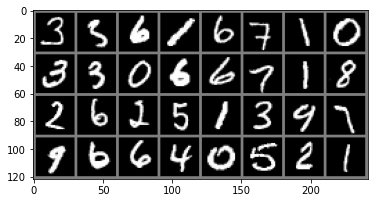

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
 
        self.fc1 = nn.Linear(9216, 128)# Why 9216? because in the forward funtion, this input of this layer has 9216 length, like [32, 9216], where 32 is the batch_size we set at line 18
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)  # change a matrix or feature map like [32, aa, bb, cc] to [32, aa X bb X cc]
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        #output = F.log_softmax(x, dim=1)  because we use nn.CrossEntropyLoss() as the loss function, it already include log_softmax
        return output


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


net = Net().to(device)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

def train():
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Finished Training')


    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)

def test():
    net = Net().to(device)
    PATH = './cifar_net.pth'
    para = torch.load(PATH)
    net.load_state_dict(para)


    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
def showdata():
    import matplotlib.pyplot as plt
    import numpy as np

    # functions to show an image
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.savefig('dataset.png')

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    
if __name__ == '__main__':
    showdata()
    train()
    test()

In [56]:
# for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             print(i, data)
#             break

In [58]:
# nn parameters: num_filters = 32, filter_size = (5,5), gain = 'relu'
# Conv2DLayer(incoming, num_filters, filter_size, stride=(1, 1), pad=0,
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
            
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 32, 5, 1)
 
        self.fc1 = nn.Linear(9216, 128)# Why 9216? because in the forward funtion, this input of this layer has 9216 length, like [32, 9216], where 32 is the batch_size we set at line 18
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = F.tanh(x)
        output = x
        # x = torch.flatten(x, 1)  # change a matrix or feature map like [32, aa, bb, cc] to [32, aa X bb X cc]
        # x = self.fc1(x)
        # x = F.relu(x)
        # output = self.fc2(x)
        #output = F.log_softmax(x, dim=1)  because we use nn.CrossEntropyLoss() as the loss function, it already include log_softmax
        return output


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


net = Net().to(device)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def train():
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Finished Training')


    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)

def test():
    net = Net().to(device)
    PATH = './cifar_net.pth'
    para = torch.load(PATH)
    net.load_state_dict(para)


    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
def showdata():
    import matplotlib.pyplot as plt
    import numpy as np

    # functions to show an image
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.savefig('dataset.png')

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    
if __name__ == '__main__':
    # showdata()
    train()
    test()

Using cuda device


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: ignored

In [17]:
in1 = ""
l1 = ""
for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            in1 = data
            break

In [18]:
in1.shape

torch.Size([100, 28, 28])